This project is partially based on the notebook that was created for the peer review assignment in the ‘Machine Learning with Python’
course which is part of the ‘IBM Data Science Professional Certificate’ by IBM available online on Coursera https://www.coursera.org/learn/machine-learning-with-python. <br>

Dataset was prepared by IBM, preliminary data exploration, visualization and preparation steps are based in part on notebook provided
for the course participants and created by Saeed Aghabozorgi, PhD. <br> 

Classifier used in the project:
-	K Nearest Neighbor (KNN),
-	Decision Tree,
-	Random Forest (not covered in course exercise),
-	Support Vector Machine,
-	Logistic Regression.


This project contains the following modifications:
- since wget is not available natively on Windows we implemented file download with the urllib.request module,
- we visualized chosen feature before and after use of StandardScaler,
- we used the GridSearchCV for finding hyperparameters for discussed classifiers,
- since provided dataset is unbalanced, we implemented three ways of tackling this problem:
    - use of class_weight feature implemented in all but KNN classifiers to find best algorithm,
    - use resampling method,
    - use of SMOTE (Synthetic Minority Oversampling Technique) from imblearn, <br>
- because main goal of the model is to identify clients that are most likely to defaults on their debt, we choose the F1 score as to score models inside GridSearchCV. Use of the recall leads to the models for which all predictions belong to the majority class,
- we also trained Random Forest classifier.


In [1]:
import itertools
import numpy as np
import pandas as pd
import numpy as np
from sklearn import preprocessing

In [2]:
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import matplotlib.ticker as ticker

import seaborn as sns

%matplotlib inline

In [3]:
from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

### About dataset

This dataset is about past loans. The **Loan_train.csv** data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
| -------------- | ------------------------------------------------------------------------------------- |
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant  

Let's download the dataset. Dataset is already divided to the train and test sets.

In [4]:
import urllib.request
url = 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/FinalModule_Coursera/data/loan_train.csv'
filename = 'loan_train.csv'
urllib.request.urlretrieve(url, filename)

('loan_train.csv', <http.client.HTTPMessage at 0x172f45f18e0>)

In [5]:
import urllib.request
url = 'https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv'
filename = 'loan_test.csv'
urllib.request.urlretrieve(url, filename)

('loan_test.csv', <http.client.HTTPMessage at 0x172f99f1970>)

### Load Data From CSV File

In [6]:
df = pd.read_csv('loan_train.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 346 entries, 0 to 345
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Unnamed: 0      346 non-null    int64 
 1   Unnamed: 0.1    346 non-null    int64 
 2   loan_status     346 non-null    object
 3   Principal       346 non-null    int64 
 4   terms           346 non-null    int64 
 5   effective_date  346 non-null    object
 6   due_date        346 non-null    object
 7   age             346 non-null    int64 
 8   education       346 non-null    object
 9   Gender          346 non-null    object
dtypes: int64(5), object(5)
memory usage: 27.2+ KB


### Convert to date time object

In [7]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing

Let’s see how many of each class is in our data set.

In [8]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection.

#### Inspected dataset is unbalanced

In [9]:
percent_paid = format(df['loan_status'].value_counts()[0]/df.shape[0]*100, '.1f')
percent_coll = format(df['loan_status'].value_counts()[1]/df.shape[0]*100, '.1f')
print(f'Percentage of clients that paidoff is {percent_paid}%.')
print(f'Percentage of clients that gone in to collection is {percent_coll}%.')

Percentage of clients that paidoff is 75.1%.
Percentage of clients that gone in to collection is 24.9%.


Let's plot some columns to underestand data better:

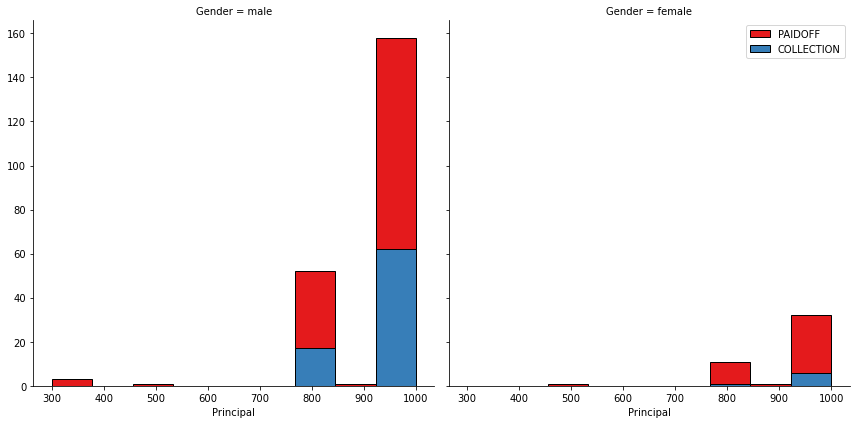

In [10]:
bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2, height=6, aspect=1.0)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

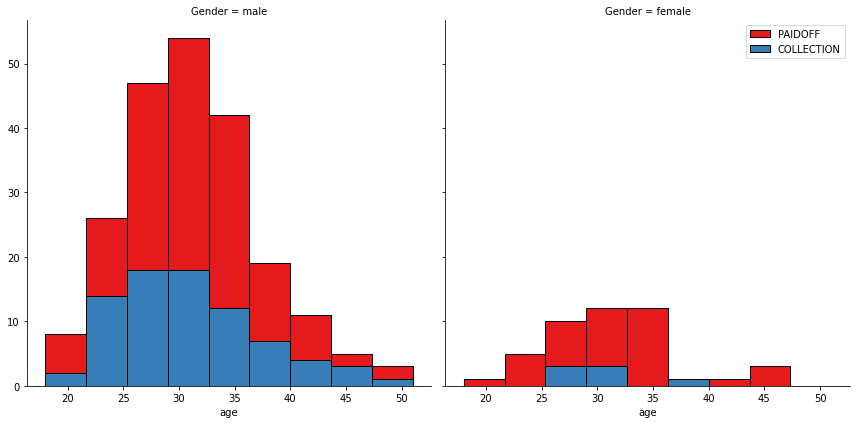

In [11]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2, height=6, aspect=1.0)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction

### Let's look at the day of the week people get the loan

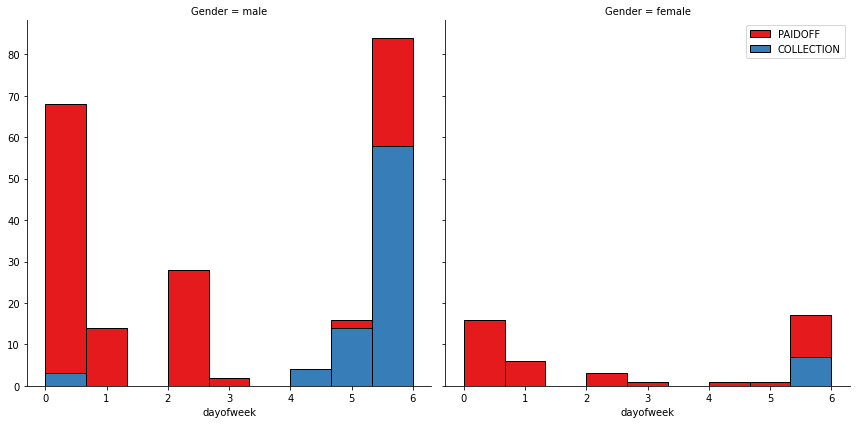

In [12]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2, height=6, aspect=1.0)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()

We see that people who get the loan at the end of the week don't pay it off, so let's use Feature binarization to set a threshold value less than day 4.

In [13]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


## Convert Categorical features to numerical values

Let's look at gender:

In [14]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan.

Let's convert male to 0 and female to 1:

In [15]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


## One Hot Encoding

#### How about education?

In [16]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

#### Features before One Hot Encoding

In [17]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


#### Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame

In [18]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


In [19]:
# alternative way
# cat_feats = ['education']
# Feature = pd.get_dummies(df,columns = cat_feats, drop_first=True)
# Feature.drop(['Master or Above'], axis = 1,inplace=True)

### Feature Selection

Let's define feature sets, X:

In [20]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


In [21]:
features_columns_list = Feature.columns.values.tolist()

What are our lables?

In [22]:
y = df['loan_status'].values
y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

#### Converting to binary values PAIDOFF = 0, COLLECTION = 1 for beter compatibility with various score functions

In [23]:
y = df['loan_status'].replace(to_replace=['PAIDOFF','COLLECTION'], value=[0,1])

In [24]:
y.value_counts()

0    260
1     86
Name: loan_status, dtype: int64

In [25]:
# fig_sc, axes_sc = plt.subplots(nrows = 1, ncols = 1 , figsize=(10,6))
# sns.scatterplot(x = Feature['weekend'], y = Feature['age'], hue = y, ax = axes_sc)

# plt.tight_layout()
# plt.show()

## Normalize Data

Data Standardization give data zero mean and unit variance (technically should be done after train test split) <br>
(IBM provides test data in separate file)

In [26]:
X = preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679]])

Converting np.array to DataFrame for ploting puropse.

In [27]:
Features_after = pd.DataFrame(X,columns=features_columns_list)

In [28]:
df_for_histplot_pl1 = [Feature, 
                   Features_after
                      ]

hist_plot_list_pl1 = ['age']*2
xlabel_list_pl1 = ['Clieants Age Before Features Rescaling',  'Clieants Age After Features Rescaling']

In [29]:
bins_number = 10

bins_set_prev = np.linspace(Feature.iloc[:,2].min(), Feature.iloc[:,2].max(), bins_number)
count_prev, bin_edges_prev = np.histogram(Feature.iloc[:,2], bins = bins_set_prev)

bins_set_aft = np.linspace(Features_after.iloc[:,2].min(), Features_after.iloc[:,2].max(), bins_number)
count_aft, bin_edges_aft = np.histogram(Features_after.iloc[:,2], bins = bins_set_aft)

bins_list_pl1 = [bin_edges_prev, bin_edges_aft]

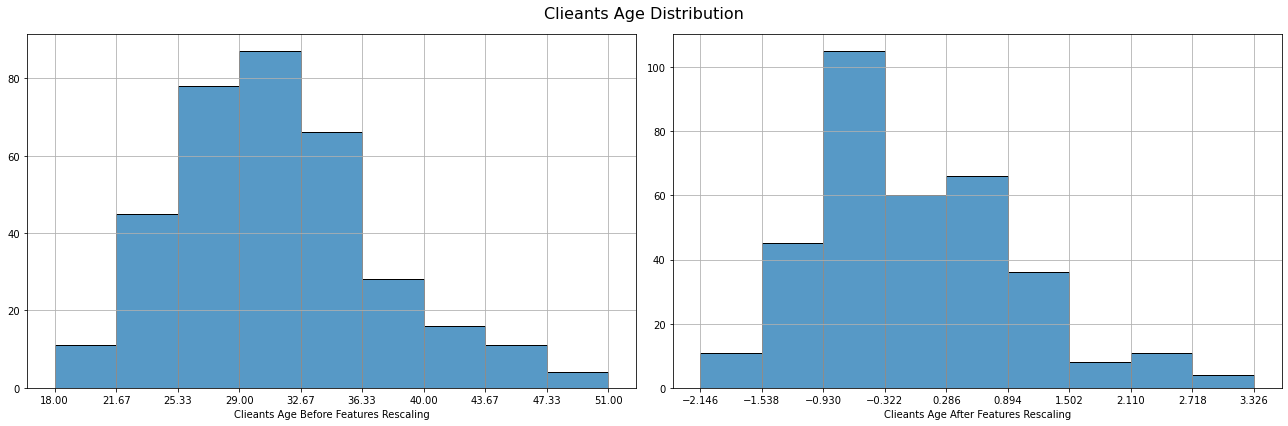

In [30]:
fig_hist_pl1, axes_hist_pl1 = plt.subplots(nrows = 1, ncols = 2 , figsize=(18,6))


for i, item in enumerate(hist_plot_list_pl1):
   
    sns.histplot(data = df_for_histplot_pl1[i], x = item, color="C0", ax = axes_hist_pl1[i], bins = bins_list_pl1[i])
    axes_hist_pl1[i].set_xticks(bins_list_pl1[i])
    axes_hist_pl1[i].grid(True)
    axes_hist_pl1[i].set_xlabel(xlabel_list_pl1[i])
    axes_hist_pl1[i].set_ylabel('')

plt.suptitle('Clieants Age Distribution', fontsize = 16)
plt.tight_layout()
plt.show()

### Load Test set for evaluation

In [31]:
test_df = pd.read_csv('loan_test.csv')
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Unnamed: 0      54 non-null     int64 
 1   Unnamed: 0.1    54 non-null     int64 
 2   loan_status     54 non-null     object
 3   Principal       54 non-null     int64 
 4   terms           54 non-null     int64 
 5   effective_date  54 non-null     object
 6   due_date        54 non-null     object
 7   age             54 non-null     int64 
 8   education       54 non-null     object
 9   Gender          54 non-null     object
dtypes: int64(5), object(5)
memory usage: 4.3+ KB


In [32]:
test_df['effective_date'] = pd.to_datetime(test_df['effective_date'])
test_df['dayofweek'] = test_df['effective_date'].dt.dayofweek
test_df['weekend'] = test_df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)

In [33]:
test_df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)

In [34]:
Feature_test = test_df[['Principal','terms','age','Gender','weekend']]
Feature_test = pd.concat([Feature_test,pd.get_dummies(test_df['education'])], axis=1)
Feature_test.drop(['Master or Above'], axis = 1,inplace=True)
Feature_test.head()

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,50,1,0,1,0,0
1,300,7,35,0,1,0,0,0
2,1000,30,43,1,1,0,1,0
3,1000,30,26,0,1,0,0,1
4,800,15,29,0,1,1,0,0


In [35]:
X_test = Feature_test
X_test_scaled = preprocessing.StandardScaler().fit(X_test).transform(X_test)

In [36]:
y_test = test_df['loan_status'].replace(to_replace=['PAIDOFF','COLLECTION'], value=[0,1])

# Imports of libraries for model testing and scoring

In [37]:
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.model_selection import GridSearchCV

# Dealing with imbalance of dataset with class_weight parameters (except for KNN)

## K Nearest Neighbor(KNN)

In [38]:
from sklearn.neighbors import KNeighborsClassifier

#### Looking for best parameters for KNN.

In [39]:
#create new a knn model
knnCV = KNeighborsClassifier()
k_max = 13
#create a dictionary of all values we want to test for n_neighbors
grid_values_KNN = {'n_neighbors': np.arange(1, k_max), 
              'weights' : ['uniform', 'distance']}
#use gridsearch to test all values for n_neighbors
knn_gscv = GridSearchCV(knnCV, param_grid = grid_values_KNN, scoring = 'f1')
#fit model to data
knn_gscv.fit(X, y)

GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]),
                         'weights': ['uniform', 'distance']},
             scoring='f1')

In [40]:
#check top performing hyperparameters value
knn_gscv.best_params_

{'n_neighbors': 7, 'weights': 'uniform'}

In [41]:
#check mean score for the top performing value of n_neighbors
knn_gscv.best_score_

0.387781469176818

In [42]:
pred_KNN_grid = knn_gscv.predict(X_test_scaled)
KNN_report_dict = classification_report(y_test,pred_KNN_grid, output_dict = True)
KNN_report = classification_report(y_test,pred_KNN_grid)
print(KNN_report)

              precision    recall  f1-score   support

           0       0.78      0.88      0.82        40
           1       0.44      0.29      0.35        14

    accuracy                           0.72        54
   macro avg       0.61      0.58      0.59        54
weighted avg       0.69      0.72      0.70        54



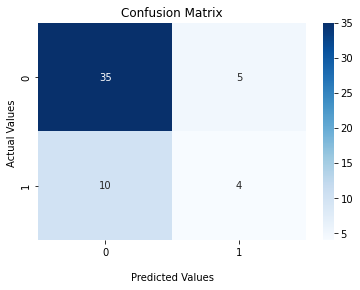

In [43]:
#print(confusion_matrix(y_original_test,predictions_original))
cf_matrix = confusion_matrix(y_test,pred_KNN_grid)

ax = sns.heatmap(cf_matrix, annot=True, fmt='.0f', cmap='Blues')

ax.set_title('Confusion Matrix');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['0','1'])
ax.yaxis.set_ticklabels(['0','1'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [44]:
KNN_jaccard = jaccard_score(y_test,pred_KNN_grid)
KNN_F1 = f1_score(y_test,pred_KNN_grid)
KNN_accuracy = KNN_report_dict['accuracy']
KNN_recall_1 = KNN_report_dict['1']['recall']

## Decision Tree

In [45]:
from sklearn.tree import DecisionTreeClassifier

In [46]:
#dtree = DecisionTreeClassifier(class_weight='balanced')

dtree = DecisionTreeClassifier()
#create a dictionary of all values we want to test for n_neighbors
grid_values_DT = {'class_weight':['balanced', {1:1.5},{1:2},{1:2.5},{1:3},{1: 4}]}

#use gridsearch to test all values for n_neighbors
DT_gscv = GridSearchCV(dtree, param_grid= grid_values_DT, scoring = 'f1')
#fit model to data
DT_gscv.fit(X, y)

GridSearchCV(estimator=DecisionTreeClassifier(),
             param_grid={'class_weight': ['balanced', {1: 1.5}, {1: 2},
                                          {1: 2.5}, {1: 3}, {1: 4}]},
             scoring='f1')

In [47]:
DT_gscv.best_params_

{'class_weight': 'balanced'}

In [48]:
DT_gscv.best_score_

0.4267685854042676

In [49]:
pred_DT = DT_gscv.predict(X_test_scaled)

DT_report_dict = classification_report(y_test,pred_DT, output_dict = True)
DT_report = classification_report(y_test,pred_DT)
print(DT_report)

              precision    recall  f1-score   support

           0       0.79      0.68      0.73        40
           1       0.35      0.50      0.41        14

    accuracy                           0.63        54
   macro avg       0.57      0.59      0.57        54
weighted avg       0.68      0.63      0.65        54



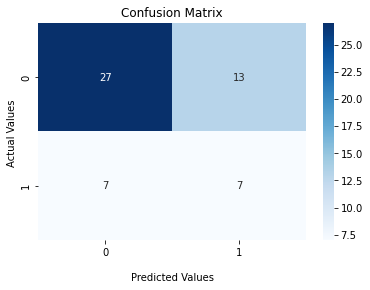

In [50]:
#print(confusion_matrix(y_original_test,predictions_original))
cf_matrix = confusion_matrix(y_test,pred_DT)

ax = sns.heatmap(cf_matrix, annot=True, fmt='.0f', cmap='Blues')

ax.set_title('Confusion Matrix');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['0','1'])
ax.yaxis.set_ticklabels(['0','1'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [51]:
DT_jaccard = jaccard_score(y_test,pred_DT)
DT_F1 = f1_score(y_test,pred_DT)
DT_accuracy = DT_report_dict['accuracy']
DT_recall_1 = DT_report_dict['1']['recall']

In [52]:
# from IPython.display import Image   
# from sklearn.tree import export_graphviz
# import pydot
# import pydotplus 

In [53]:
#features_list = list(Feature.columns[:])

In [54]:
# # Export resulting tree to DOT source code string
# dot_data = export_graphviz(dtree,
#                                 feature_names=features_list,
#                                 out_file=None,
#                                 filled=True,
#                                 rounded=True)

# pydot_graph = pydotplus.graph_from_dot_data(dot_data)
# #pydot_graph.set_size('"5,5!"')
# pydot_graph.write_png('tree.png')

In [55]:
#Image(filename='tree.png', width=5000, unconfined = True) 

## Random Forest

In [56]:
from sklearn.ensemble import RandomForestClassifier

In [57]:
forest = RandomForestClassifier()
#create a dictionary of all values we want to test for n_neighbors
grid_values_forest = {'class_weight':['balanced', {1:1.5},{1:2},{1:2.5},{1:3},{1: 4}], 
                      'n_estimators' : [50,100,200,300]}

#use gridsearch to test all values for n_neighbors
forest_gscv = GridSearchCV(forest, param_grid= grid_values_forest, scoring = 'f1', n_jobs = 4)
#fit model to data
forest_gscv.fit(X, y)

GridSearchCV(estimator=RandomForestClassifier(), n_jobs=4,
             param_grid={'class_weight': ['balanced', {1: 1.5}, {1: 2},
                                          {1: 2.5}, {1: 3}, {1: 4}],
                         'n_estimators': [50, 100, 200, 300]},
             scoring='f1')

In [58]:
forest_gscv.best_params_

{'class_weight': {1: 3}, 'n_estimators': 100}

In [59]:
forest_gscv.best_score_

0.4622140211945309

In [60]:
pred_forest = forest_gscv.predict(X_test_scaled)

forest_report_dict = classification_report(y_test,pred_forest, output_dict = True)
forest_report = classification_report(y_test,pred_forest)
print(forest_report)

              precision    recall  f1-score   support

           0       0.80      0.80      0.80        40
           1       0.43      0.43      0.43        14

    accuracy                           0.70        54
   macro avg       0.61      0.61      0.61        54
weighted avg       0.70      0.70      0.70        54



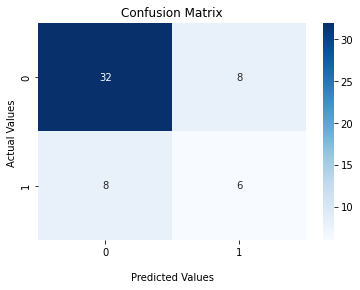

In [61]:
#print(confusion_matrix(y_original_test,predictions_original))
cf_matrix = confusion_matrix(y_test,pred_forest)

ax = sns.heatmap(cf_matrix, annot=True, fmt='.0f', cmap='Blues')

ax.set_title('Confusion Matrix');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['0','1'])
ax.yaxis.set_ticklabels(['0','1'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [62]:
forest_jaccard = jaccard_score(y_test,pred_forest)
forest_F1 = f1_score(y_test,pred_forest)
forest_accuracy = forest_report_dict['accuracy']
forest_recall_1 = forest_report_dict['1']['recall']

## Support Vector Machine

In [63]:
from sklearn.svm import SVC

In [64]:
#svm = SVC(class_weight='balanced')

svm = SVC()
#create a dictionary of all values we want to test for n_neighbors
C_range = np.logspace(-3, 3, 7)
gamma_range = np.logspace(-3, 3, 7)

grid_values_SVM = {'class_weight':['balanced', {1:1.5},{1:2},{1:2.5},{1:3},{1: 4}], 
               'C' : C_range, 
               'gamma' : gamma_range}



#use gridsearch to test all values for n_neighbors
svm_gscv = GridSearchCV(svm, param_grid= grid_values_SVM, scoring = 'f1')
#fit model to data
svm_gscv.fit(X, y)

GridSearchCV(estimator=SVC(),
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'class_weight': ['balanced', {1: 1.5}, {1: 2},
                                          {1: 2.5}, {1: 3}, {1: 4}],
                         'gamma': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])},
             scoring='f1')

In [65]:
svm_gscv.best_params_

{'C': 0.1, 'class_weight': {1: 4}, 'gamma': 0.1}

In [66]:
svm_gscv.best_score_

0.6690081563199843

In [67]:
pred_SVM = svm_gscv.predict(X_test_scaled)

SVM_report_dict = classification_report(y_test,pred_SVM, output_dict = True)
SVM_report = classification_report(y_test,pred_SVM)
print(SVM_report)

              precision    recall  f1-score   support

           0       0.95      0.47      0.63        40
           1       0.38      0.93      0.54        14

    accuracy                           0.59        54
   macro avg       0.67      0.70      0.59        54
weighted avg       0.80      0.59      0.61        54



In [68]:
SVM_jaccard = jaccard_score(y_test,pred_SVM)
SVM_F1 = f1_score(y_test,pred_SVM)
SVM_accuracy = SVM_report_dict['accuracy']
SVM_recall_1 = SVM_report_dict['1']['recall']

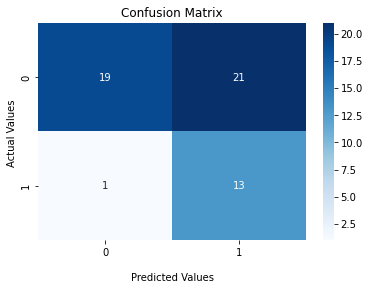

In [69]:
#print(confusion_matrix(y_original_test,predictions_original))
cf_matrix = confusion_matrix(y_test,pred_SVM)

ax = sns.heatmap(cf_matrix, annot=True, fmt='.0f', cmap='Blues')

ax.set_title('Confusion Matrix');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['0','1'])
ax.yaxis.set_ticklabels(['0','1'])

## Display the visualization of the Confusion Matrix.
plt.show()

## Logistic Regression

In [70]:
from sklearn.linear_model import LogisticRegression

In [71]:
logmodel = LogisticRegression()
#create a dictionary of all values we want to test for n_neighbors
grid_values_logreg = {'class_weight':['balanced', {1:1.5},{1:2},{1:2.5},{1:3},{1: 4}]}

#use gridsearch to test all values for n_neighbors
logreg_gscv = GridSearchCV(logmodel, param_grid= grid_values_logreg, scoring = 'f1')
#fit model to data
logreg_gscv.fit(X, y)

GridSearchCV(estimator=LogisticRegression(),
             param_grid={'class_weight': ['balanced', {1: 1.5}, {1: 2},
                                          {1: 2.5}, {1: 3}, {1: 4}]},
             scoring='f1')

In [72]:
logreg_gscv.best_params_

{'class_weight': {1: 4}}

In [73]:
logreg_gscv.best_score_

0.658876168307629

In [74]:
pred_logreg = logreg_gscv.predict(X_test_scaled)

logreg_report_dict = classification_report(y_test,pred_logreg, output_dict = True)
logreg_report = classification_report(y_test,pred_logreg)
print(logreg_report)

              precision    recall  f1-score   support

           0       0.95      0.50      0.66        40
           1       0.39      0.93      0.55        14

    accuracy                           0.61        54
   macro avg       0.67      0.71      0.60        54
weighted avg       0.81      0.61      0.63        54



In [75]:
logreg_jaccard = jaccard_score(y_test,pred_logreg)
logreg_F1 = f1_score(y_test,pred_logreg)
logreg_logloss = log_loss(y_test,pred_logreg)
logreg_accuracy = logreg_report_dict['accuracy']
logreg_recall_1 = logreg_report_dict['1']['recall']

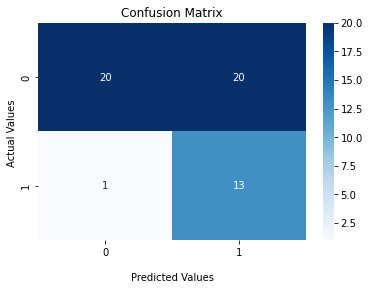

In [76]:
#print(confusion_matrix(y_original_test,predictions_original))
cf_matrix = confusion_matrix(y_test,pred_logreg)

ax = sns.heatmap(cf_matrix, annot=True, fmt='.0f', cmap='Blues')

ax.set_title('Confusion Matrix');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['0','1'])
ax.yaxis.set_ticklabels(['0','1'])

## Display the visualization of the Confusion Matrix.
plt.show()

## Report

In [77]:
report_dict = {'Algorithm' : ['KNN', 'Decision Tree', 'Random Forest', 'SVM', 'Logistic Regression'],
               'Accuracy' : ['%.3f' % member for member in [KNN_accuracy, DT_accuracy, forest_accuracy, SVM_accuracy, logreg_accuracy]],
               'Jaccard' : ['%.3f' % member for member in [KNN_jaccard, DT_jaccard, forest_jaccard, SVM_jaccard, logreg_jaccard]], 
               'F1-score' : ['%.3f' % member for member in [KNN_F1, DT_F1, forest_F1, SVM_F1, logreg_F1]], 
               'LogLoss' : ['NA', 'NA', 'NA', 'NA', format(logreg_logloss,'.3f')]}

In [78]:
report_df = pd.DataFrame.from_dict(report_dict).set_index('Algorithm')

In [79]:
report_df

,Accuracy,Jaccard,F1-score,LogLoss
Algorithm,,,,
KNN,0.722,0.211,0.348,NA
Decision Tree,0.630,0.259,0.412,NA
Random Forest,0.704,0.273,0.429,NA
SVM,0.593,0.371,0.542,NA
Logistic Regression,0.611,0.382,0.553,13.432


# Use of the resampling to deal with imbalance in data

We oversample minority class (essentially duplicate points in this class) to bring it to the same count as the majority class.

In [80]:
from sklearn.utils import resample

In [81]:
def adjust_imbalance(X_train, y_train, class_col):
    '''
    class imbalance adjustment
    code assimilated from https://www.thepythoncode.com/article/handling-imbalanced-datasets-sklearn-in-python
    '''
    X = pd.concat([X_train, y_train], axis=1)
    # separate the 2 classes. Here we divide majority and minority classes
    class0 = X[X[class_col] == 0]
    class1 = X[X[class_col] == 1]
    # Case 1 - bootstraps from the minority class
    if len(class1)<len(class0):
        resampled = resample(class1,
                             replace=True, # Upsampling with replacement
                             n_samples=len(class0), ## Number to match majority class
                             random_state=10) 
        resampled_data = pd.concat([resampled, class0]) ## # Combination of majority and upsampled minority class
        # Case 1 - resamples from the majority class
    else:
        resampled = resample(class1,
                             replace=False, ## false instead of True like above
                             n_samples=len(class0), 
                             random_state=10) 
        resampled_data = pd.concat([resampled, class0])
    return resampled_data

In [82]:
resampled_data = adjust_imbalance(Feature, y, class_col='loan_status')

In [83]:
resampled_data['loan_status'].value_counts()

1    260
0    260
Name: loan_status, dtype: int64

In [84]:
X_resampled = resampled_data[features_columns_list]

In [85]:
X_resampled.head()

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
269,1000,30,30,0,1,0,1,0
275,1000,30,37,0,1,0,0,1
324,1000,30,33,0,1,0,0,1
288,1000,30,23,0,1,0,1,0
289,1000,15,27,1,1,0,0,1


In [86]:
y_resampled = resampled_data['loan_status'].replace(to_replace=['PAIDOFF','COLLECTION'], value=[0,1])

In [87]:
X_resampled = preprocessing.StandardScaler().fit(X_resampled).transform(X_resampled)

## KNN

In [88]:
#create new a knn model
knnCV = KNeighborsClassifier()
k_max = 13
#create a dictionary of all values we want to test for n_neighbors
grid_values_KNN = {'n_neighbors': np.arange(1, k_max), 
              'weights' : ['uniform', 'distance']}
#use gridsearch to test all values for n_neighbors
knn_gscv = GridSearchCV(knnCV, param_grid = grid_values_KNN, scoring = 'f1')
#fit model to data
knn_gscv.fit(X_resampled, y_resampled)

GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]),
                         'weights': ['uniform', 'distance']},
             scoring='f1')

In [89]:
pred_KNN_grid = knn_gscv.predict(X_test_scaled)
KNN_report_dict = classification_report(y_test,pred_KNN_grid, output_dict = True)
KNN_report = classification_report(y_test,pred_KNN_grid)
print(KNN_report)

              precision    recall  f1-score   support

           0       0.81      0.75      0.78        40
           1       0.41      0.50      0.45        14

    accuracy                           0.69        54
   macro avg       0.61      0.62      0.62        54
weighted avg       0.71      0.69      0.69        54



In [90]:
KNN_jaccard_resampled = jaccard_score(y_test,pred_KNN_grid)
KNN_F1_resampled = f1_score(y_test,pred_KNN_grid)
KNN_accuracy_resampled = KNN_report_dict['accuracy']
KNN_recall_1_resampled = KNN_report_dict['1']['recall']

## Decision Tree

In [91]:
#dtree = DecisionTreeClassifier(class_weight='balanced')

dtree = DecisionTreeClassifier()
#create a dictionary of all values we want to test for n_neighbors
grid_values_DT = {'class_weight':[{1:1}]}

#use gridsearch to test all values for n_neighbors
DT_gscv = GridSearchCV(dtree, param_grid= grid_values_DT, scoring = 'f1')
#fit model to data
DT_gscv.fit(X_resampled, y_resampled)

GridSearchCV(estimator=DecisionTreeClassifier(),
             param_grid={'class_weight': [{1: 1}]}, scoring='f1')

In [92]:
pred_DT = DT_gscv.predict(X_test_scaled)

DT_report_dict = classification_report(y_test,pred_DT, output_dict = True)
DT_report = classification_report(y_test,pred_DT)
print(DT_report)

              precision    recall  f1-score   support

           0       0.85      0.82      0.84        40
           1       0.53      0.57      0.55        14

    accuracy                           0.76        54
   macro avg       0.69      0.70      0.69        54
weighted avg       0.77      0.76      0.76        54



In [93]:
DT_jaccard_resampled = jaccard_score(y_test,pred_DT)
DT_F1_resampled = f1_score(y_test,pred_DT)
DT_accuracy_resampled = DT_report_dict['accuracy']
DT_recall_1_resampled = DT_report_dict['1']['recall']

## Random Forest

In [94]:
forest = RandomForestClassifier()
#create a dictionary of all values we want to test for n_neighbors
grid_values_forest = {'class_weight':['balanced', {1:1.5},{1:2},{1:2.5},{1:3},{1: 4}], 
                      'n_estimators' : [50,100,200,300]}

#use gridsearch to test all values for n_neighbors
forest_gscv = GridSearchCV(forest, param_grid= grid_values_forest, scoring = 'f1', n_jobs = 4)
#fit model to data
forest_gscv.fit(X_resampled, y_resampled)

GridSearchCV(estimator=RandomForestClassifier(), n_jobs=4,
             param_grid={'class_weight': ['balanced', {1: 1.5}, {1: 2},
                                          {1: 2.5}, {1: 3}, {1: 4}],
                         'n_estimators': [50, 100, 200, 300]},
             scoring='f1')

In [95]:
pred_forest = forest_gscv.predict(X_test_scaled)

forest_report_dict = classification_report(y_test,pred_forest, output_dict = True)
forest_report = classification_report(y_test,pred_forest)
print(forest_report)

              precision    recall  f1-score   support

           0       0.79      0.68      0.73        40
           1       0.35      0.50      0.41        14

    accuracy                           0.63        54
   macro avg       0.57      0.59      0.57        54
weighted avg       0.68      0.63      0.65        54



In [96]:
forest_jaccard_resampled = jaccard_score(y_test,pred_forest)
forest_F1_resampled = f1_score(y_test,pred_forest)
forest_accuracy_resampled = forest_report_dict['accuracy']
forest_recall_1_resampled = forest_report_dict['1']['recall']

## Support Vector Machine

In [97]:
#svm = SVC(class_weight='balanced')

svm = SVC()
#create a dictionary of all values we want to test for n_neighbors
C_range = np.logspace(-3, 3, 7)
gamma_range = np.logspace(-3, 3, 7)

grid_values_SVM = {
               'C' : C_range, 
               'gamma' : gamma_range}



#use gridsearch to test all values for n_neighbors
svm_gscv = GridSearchCV(svm, param_grid= grid_values_SVM, scoring = 'f1')
#fit model to data
svm_gscv.fit(X_resampled, y_resampled)

GridSearchCV(estimator=SVC(),
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'gamma': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])},
             scoring='f1')

In [98]:
pred_SVM = svm_gscv.predict(X_test_scaled)

SVM_report_dict = classification_report(y_test,pred_SVM, output_dict = True)
SVM_report = classification_report(y_test,pred_SVM)
print(SVM_report)

              precision    recall  f1-score   support

           0       0.76      0.95      0.84        40
           1       0.50      0.14      0.22        14

    accuracy                           0.74        54
   macro avg       0.63      0.55      0.53        54
weighted avg       0.69      0.74      0.68        54



In [99]:
SVM_jaccard_resampled = jaccard_score(y_test,pred_SVM)
SVM_F1_resampled = f1_score(y_test,pred_SVM)
SVM_accuracy_resampled = SVM_report_dict['accuracy']
SVM_recall_1_resampled = SVM_report_dict['1']['recall']

## Logistic Regression

In [100]:
logmodel = LogisticRegression()
#create a dictionary of all values we want to test for n_neighbors
grid_values_logreg = {'class_weight':[ {1:1}]}

#use gridsearch to test all values for n_neighbors
logreg_gscv = GridSearchCV(logmodel, param_grid= grid_values_logreg, scoring = 'f1')
#fit model to data
logreg_gscv.fit(X_resampled, y_resampled)

GridSearchCV(estimator=LogisticRegression(),
             param_grid={'class_weight': [{1: 1}]}, scoring='f1')

In [101]:
pred_logreg = logreg_gscv.predict(X_test_scaled)

logreg_report_dict = classification_report(y_test,pred_logreg, output_dict = True)
logreg_report = classification_report(y_test,pred_logreg)
print(logreg_report)

              precision    recall  f1-score   support

           0       0.95      0.47      0.63        40
           1       0.38      0.93      0.54        14

    accuracy                           0.59        54
   macro avg       0.67      0.70      0.59        54
weighted avg       0.80      0.59      0.61        54



In [102]:
logreg_jaccard_resampled = jaccard_score(y_test,pred_logreg)
logreg_F1_resampled = f1_score(y_test,pred_logreg)
logreg_logloss_resampled = log_loss(y_test,pred_logreg)
logreg_accuracy_resampled = logreg_report_dict['accuracy']
logreg_recall_1_resampled = logreg_report_dict['1']['recall']

## Report

In [103]:
report_dict_resampled = {'Algorithm' : ['KNN', 'Decision Tree', 'Random Forest', 'SVM', 'Logistic Regression'],
                         'Accuracy' : ['%.3f' % member for member in [KNN_accuracy_resampled, DT_accuracy_resampled, forest_accuracy_resampled, 
                                                                      SVM_accuracy_resampled, logreg_accuracy_resampled]],
                         'Jaccard' : ['%.3f' % member for member in [KNN_jaccard_resampled, DT_jaccard_resampled, forest_accuracy_resampled, 
                                                                     SVM_jaccard_resampled, logreg_jaccard_resampled]], 
                         'F1-score' : ['%.3f' % member for member in [KNN_F1_resampled, DT_F1_resampled, forest_accuracy_resampled, 
                                                                      SVM_F1_resampled, logreg_F1_resampled]], 
                         'LogLoss' : ['NA', 'NA', 'NA','NA', format(logreg_logloss_resampled,'.3f')]}
report_df_resampled = pd.DataFrame.from_dict(report_dict_resampled).set_index('Algorithm')

In [104]:
report_df_resampled

,Accuracy,Jaccard,F1-score,LogLoss
Algorithm,,,,
KNN,0.685,0.292,0.452,NA
Decision Tree,0.759,0.381,0.552,NA
Random Forest,0.630,0.630,0.630,NA
SVM,0.741,0.125,0.222,NA
Logistic Regression,0.593,0.371,0.542,14.072


# Use of SMOTE (Synthetic Minority Oversampling Technique)

N. V. Chawla, K. W. Bowyer, L. O. Hall, W. P. Kegelmeyer, 'SMOTE: Synthetic Minority Over-sampling Technique', <br>
Journal Of Artificial Intelligence Research, Volume 16, pages 321-357, 2002 (arXiv:1106.1813) <br>
https://doi.org/10.1613/jair.953


We create synthetic points in minority class to increase they numbers to much the majority class. <br>
(Some info nice info on how to implement this can be found on https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/)

In [105]:
from imblearn.over_sampling import SMOTE

In [106]:
# transform the dataset
oversample = SMOTE()
X_SMOTE, y_SMOTE = oversample.fit_resample(X, y)

In [107]:
y_SMOTE.value_counts()

0    260
1    260
Name: loan_status, dtype: int64

## KNN

In [108]:
#create new a knn model
knnCV = KNeighborsClassifier()
k_max = 13
#create a dictionary of all values we want to test for n_neighbors
grid_values_KNN = {'n_neighbors': np.arange(1, k_max), 
              'weights' : ['uniform', 'distance']}
#use gridsearch to test all values for n_neighbors
knn_gscv = GridSearchCV(knnCV, param_grid = grid_values_KNN, scoring = 'f1')
#fit model to data
knn_gscv.fit(X_SMOTE, y_SMOTE)

GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]),
                         'weights': ['uniform', 'distance']},
             scoring='f1')

In [109]:
pred_KNN_grid = knn_gscv.predict(X_test_scaled)
KNN_report_dict = classification_report(y_test,pred_KNN_grid, output_dict = True)
KNN_report = classification_report(y_test,pred_KNN_grid)
print(KNN_report)

              precision    recall  f1-score   support

           0       0.84      0.68      0.75        40
           1       0.41      0.64      0.50        14

    accuracy                           0.67        54
   macro avg       0.63      0.66      0.62        54
weighted avg       0.73      0.67      0.69        54



In [110]:
KNN_jaccard_SMOTE = jaccard_score(y_test,pred_KNN_grid)
KNN_F1_SMOTE = f1_score(y_test,pred_KNN_grid)
KNN_accuracy_SMOTE = KNN_report_dict['accuracy']
KNN_recall_1_SMOTE = KNN_report_dict['1']['recall']

## Decision Tree

In [111]:
#dtree = DecisionTreeClassifier(class_weight='balanced')

dtree = DecisionTreeClassifier()
#create a dictionary of all values we want to test for n_neighbors
grid_values_DT = {'class_weight':[{1:1}]}

#use gridsearch to test all values for n_neighbors
DT_gscv = GridSearchCV(dtree, param_grid= grid_values_DT, scoring = 'f1')
#fit model to data
DT_gscv.fit(X_SMOTE, y_SMOTE)

GridSearchCV(estimator=DecisionTreeClassifier(),
             param_grid={'class_weight': [{1: 1}]}, scoring='f1')

In [112]:
pred_DT = DT_gscv.predict(X_test_scaled)

DT_report_dict = classification_report(y_test,pred_DT, output_dict = True)
DT_report = classification_report(y_test,pred_DT)
print(DT_report)

              precision    recall  f1-score   support

           0       0.96      0.60      0.74        40
           1       0.45      0.93      0.60        14

    accuracy                           0.69        54
   macro avg       0.70      0.76      0.67        54
weighted avg       0.83      0.69      0.70        54



In [113]:
DT_jaccard_SMOTE = jaccard_score(y_test,pred_DT)
DT_F1_SMOTE = f1_score(y_test,pred_DT)
DT_accuracy_SMOTE = DT_report_dict['accuracy']
DT_recall_1_SMOTE = DT_report_dict['1']['recall']

## Random Forest

In [114]:
forest = RandomForestClassifier()
#create a dictionary of all values we want to test for n_neighbors
grid_values_forest = {'class_weight':['balanced', {1:1.5},{1:2},{1:2.5},{1:3},{1: 4}], 
                      'n_estimators' : [50,100,200,300]}

#use gridsearch to test all values for n_neighbors
forest_gscv = GridSearchCV(forest, param_grid= grid_values_forest, scoring = 'f1', n_jobs = 4)
#fit model to data
forest_gscv.fit(X_SMOTE, y_SMOTE)

GridSearchCV(estimator=RandomForestClassifier(), n_jobs=4,
             param_grid={'class_weight': ['balanced', {1: 1.5}, {1: 2},
                                          {1: 2.5}, {1: 3}, {1: 4}],
                         'n_estimators': [50, 100, 200, 300]},
             scoring='f1')

In [115]:
pred_forest = forest_gscv.predict(X_test_scaled)

forest_report_dict = classification_report(y_test,pred_forest, output_dict = True)
forest_report = classification_report(y_test,pred_forest)
print(forest_report)

              precision    recall  f1-score   support

           0       0.89      0.60      0.72        40
           1       0.41      0.79      0.54        14

    accuracy                           0.65        54
   macro avg       0.65      0.69      0.63        54
weighted avg       0.76      0.65      0.67        54



In [116]:
forest_jaccard_SMOTE = jaccard_score(y_test,pred_forest)
forest_F1_SMOTE = f1_score(y_test,pred_forest)
forest_accuracy_SMOTE = forest_report_dict['accuracy']
forest_recall_1_SMOTE = forest_report_dict['1']['recall']

## SVM

In [117]:
#svm = SVC(class_weight='balanced')

svm = SVC()
#create a dictionary of all values we want to test for n_neighbors
C_range = np.logspace(-3, 3, 7)
gamma_range = np.logspace(-3, 3, 7)

grid_values_SVM = {
               'C' : C_range, 
               'gamma' : gamma_range}



#use gridsearch to test all values for n_neighbors
svm_gscv = GridSearchCV(svm, param_grid= grid_values_SVM, scoring = 'f1')
#fit model to data
svm_gscv.fit(X_SMOTE, y_SMOTE)

GridSearchCV(estimator=SVC(),
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'gamma': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])},
             scoring='f1')

In [118]:
pred_SVM = svm_gscv.predict(X_test_scaled)

SVM_report_dict = classification_report(y_test,pred_SVM, output_dict = True)
SVM_report = classification_report(y_test,pred_SVM)
print(SVM_report)

              precision    recall  f1-score   support

           0       0.87      0.65      0.74        40
           1       0.42      0.71      0.53        14

    accuracy                           0.67        54
   macro avg       0.64      0.68      0.63        54
weighted avg       0.75      0.67      0.69        54



In [119]:
SVM_jaccard_SMOTE = jaccard_score(y_test,pred_SVM)
SVM_F1_SMOTE = f1_score(y_test,pred_SVM)
SVM_accuracy_SMOTE = SVM_report_dict['accuracy']
SVM_recall_1_SMOTE = SVM_report_dict['1']['recall']

## Logistic Regression

In [120]:
logmodel = LogisticRegression()
#create a dictionary of all values we want to test for n_neighbors
grid_values_logreg = {'class_weight':[ {1:1}]}

#use gridsearch to test all values for n_neighbors
logreg_gscv = GridSearchCV(logmodel, param_grid= grid_values_logreg, scoring = 'f1')
#fit model to data
logreg_gscv.fit(X_SMOTE, y_SMOTE)

GridSearchCV(estimator=LogisticRegression(),
             param_grid={'class_weight': [{1: 1}]}, scoring='f1')

In [121]:
pred_logreg = logreg_gscv.predict(X_test_scaled)

logreg_report_dict = classification_report(y_test,pred_logreg, output_dict = True)
logreg_report = classification_report(y_test,pred_logreg)
print(logreg_report)

              precision    recall  f1-score   support

           0       0.89      0.62      0.74        40
           1       0.42      0.79      0.55        14

    accuracy                           0.67        54
   macro avg       0.66      0.71      0.64        54
weighted avg       0.77      0.67      0.69        54



In [122]:
logreg_jaccard_SMOTE = jaccard_score(y_test,pred_logreg)
logreg_F1_SMOTE = f1_score(y_test,pred_logreg)
logreg_logloss_SMOTE = log_loss(y_test,pred_logreg)
logreg_accuracy_SMOTE = logreg_report_dict['accuracy']
logreg_recall_1_SMOTE = logreg_report_dict['1']['recall']

## Report

In [123]:
report_dict_SMOTE = {'Algorithm' : ['KNN', 'Decision Tree', 'Random Forest','SVM', 'Logistic Regression'],
                         'Accuracy' : ['%.3f' % member for member in [KNN_accuracy_SMOTE, DT_accuracy_SMOTE, forest_accuracy_SMOTE, 
                                                                      SVM_accuracy_SMOTE, logreg_accuracy_SMOTE]],
                         'Jaccard' : ['%.3f' % member for member in [KNN_jaccard_SMOTE, DT_jaccard_SMOTE, forest_jaccard_SMOTE, 
                                                                     SVM_jaccard_SMOTE, logreg_jaccard_SMOTE]], 
                         'F1-score' : ['%.3f' % member for member in [KNN_F1_SMOTE, DT_F1_SMOTE, forest_F1_SMOTE, 
                                                                      SVM_F1_SMOTE, logreg_F1_SMOTE]], 
                         'LogLoss' : ['NA', 'NA', 'NA','NA', format(logreg_logloss_SMOTE,'.3f')]}
report_df_SMOTE = pd.DataFrame.from_dict(report_dict_SMOTE).set_index('Algorithm')

In [124]:
report_df_SMOTE

,Accuracy,Jaccard,F1-score,LogLoss
Algorithm,,,,
KNN,0.667,0.333,0.500,NA
Decision Tree,0.685,0.433,0.605,NA
Random Forest,0.648,0.367,0.537,NA
SVM,0.667,0.357,0.526,NA
Logistic Regression,0.667,0.379,0.550,11.513


# Summary

In [125]:
report_dict_summ = {
                    ('Accuracy', 'class_weight') : ['%.3f' % member for member in [KNN_accuracy, DT_accuracy, forest_accuracy, 
                                                                                   SVM_accuracy, logreg_accuracy]], 
                    ('Accuracy', 'Oversampling') : 
                        ['%.3f' % member for member in [KNN_accuracy_resampled, DT_accuracy_resampled, forest_accuracy_resampled, 
                                                        SVM_accuracy_resampled, logreg_accuracy_resampled]], 
                    ('Accuracy', 'SMOTE') : ['%.3f' % member for member in [KNN_accuracy_SMOTE, DT_accuracy_SMOTE, forest_accuracy_SMOTE, 
                                                                            SVM_accuracy_SMOTE, logreg_accuracy_SMOTE]],
                    ('F1-score', 'class_weight') : ['%.3f' % member for member in [KNN_F1, DT_F1, forest_F1, SVM_F1, logreg_F1]], 
                    ('F1-score', 'Oversampling') : 
                        ['%.3f' % member for member in [KNN_F1_resampled, DT_F1_resampled, forest_F1_resampled, 
                                                        SVM_F1_resampled, logreg_F1_resampled]], 
                    ('F1-score', 'SMOTE') : ['%.3f' % member for member in [KNN_F1_SMOTE, DT_F1_SMOTE, forest_F1_SMOTE, 
                                                                            SVM_F1_SMOTE, logreg_F1_SMOTE]],
                    ('Recall on Collection class', 'class_weight') : ['%.3f' % member for member in [KNN_recall_1, DT_recall_1, forest_recall_1, 
                                                                                                     SVM_recall_1, logreg_recall_1]], 
                    ('Recall on Collection class', 'Oversampling') : 
                        ['%.3f' % member for member in [KNN_recall_1_resampled, DT_recall_1_resampled, forest_recall_1_resampled, 
                                                        SVM_recall_1_resampled, logreg_recall_1_resampled]], 
                    ('Recall on Collection class', 'SMOTE') : 
                        ['%.3f' % member for member in [KNN_recall_1_SMOTE, DT_recall_1_SMOTE, forest_recall_1_SMOTE, 
                                                        SVM_recall_1_SMOTE, logreg_recall_1_SMOTE]]
                   }
report_df_summ = pd.DataFrame(report_dict_summ, index = ['KNN', 'Decision Tree', 'Random Forest', 'SVM', 'Logistic Regression'])

In [126]:
report_df_summ.style.set_table_styles({
    'Logistic Regression' : [ { "selector" :"td", "props": [("background-color", "lightgreen")]}]
}, axis = 1, )

Note: there is no class_weight parameter for KNN therefore in this field we presented results for default hyperparameter set for this algorithm.

#### Results of conducted experiment may be summarized as follows:
-	accuracy is not a good metric in case at hand,
-	metric directly relevant for the posed question is recall on Collection class which tell us how many clients that gone to the defaults on their debts were correctly recognized by model,
-	considering above we choose the F1-score, which represents harmonic mean of precision and recall being our metric to compare performance of models,
-	taking in to the account this metric the Logistic Regression was the model that performed best across all considered method to deal with dataset imbalance.


<hr>
<div class="alert alert-block alert-info">
<h2> Author: <b>&#x141;ukasz Nakonieczny</b> </h2>
</div>